# KRAS proteomics cis comparison

## Step 1: Library Imports

Run this cell to import the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats

import cptac
import cptac.algorithms as al

In [2]:
def format_cis_comparison_data(cancer_object, specific_omics, gene):
    
    # Step 1 - Create dataframe in order to do comparisons with wrap_ttest - drop nan values
    omics_and_mutations = cancer_object.append_mutations_to_omics(
        mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene).dropna()

    # Check if values in omics data (if not found in proteomics, after na dropped dataframe should be empty)
    if omics_and_mutations[gene+"_"+specific_omics.name].empty:
        print('Not possible to do T-test. No data for', gene, 'in', specific_omics.name)
        return None
    else:
        
        # Step 2 - Create the binary column needed to do the comparison
        omics_and_mutations['binary_mutations'] = np.where(
            omics_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

        # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
        tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']
        columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
        omics_binary_mutations = tumors.drop(columns_to_drop, axis = 1)
        #check if only one column of omics data (total 2 columns)
        if len(omics_binary_mutations.columns) != 2:
            print('exeption with columns. check omics data')
            return None
        else:
            # Make a list of the column label of omics to be used in the wrap_ttest function
            omics_col_list = [omics_binary_mutations.columns[0]] 

            # Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
            print("Doing t-test comparison\n")
            significant_pval_results = al.wrap_ttest(omics_binary_mutations, 'binary_mutations', omics_col_list)
            print(significant_pval_results)

            formated_data_for_boxplot = {'data': omics_binary_mutations, 'x': "binary_mutations", 
                                         'y': gene+"_"+specific_omics.name, 'pval': significant_pval_results}
            return formated_data_for_boxplot

  

In [28]:
def get_missence_truncation_comparison(cancer_object, specific_omics, gene):
    specific_omics = cancer_object.get_proteomics()
    #get omics data and tumors
    omics_and_mutations = cancer_object.append_mutations_to_omics(
                mutation_genes = gene, omics_df_name = specific_omics.name, omics_genes = gene)
    tumors = omics_and_mutations.loc[omics_and_mutations['Sample_Status'] == 'Tumor']


    somatic_mutations = cancer_object.get_mutations().reset_index()

    if cancer_object.get_cancer_type() == 'colon':
        missence_truncation_groups = {'frameshift substitution': 'T', 
            'frameshift deletion': 'T', 'frameshift insertion': 'T', 
            'stopgain': 'T', 'stoploss': 'T', 'nonsynonymous SNV': 'M',
            'nonframeshift insertion': 'M','nonframeshift deletion': 'M', 
            'nonframeshift substitution': 'M'}
    else: 
        missence_truncation_groups = {'In_Frame_Del': 'M', 'In_Frame_Ins': 'M',
            'Missense_Mutation': 'M', 'Frame_Shift_Del': 'T','Nonsense_Mutation': 'T', 
            'Splice_Site': 'T', 'Frame_Shift_Ins': 'T','Nonstop_Mutation':'T'}

    mutations_replaced_M_T = somatic_mutations.replace(missence_truncation_groups)
    mutations_replaced_M_T = mutations_replaced_M_T.loc[mutations_replaced_M_T['Gene'] == gene]

    # group mutation categories
    miss = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'M']
    trunc = mutations_replaced_M_T.loc[mutations_replaced_M_T['Mutation'] == 'T']

    #get lists of unique samples for missence and trucation categories
    miss_unique_samples = list(miss['Sample_ID'].unique())
    trunc_unique_samples = list(trunc['Sample_ID'].unique())
    
    #check if there is only one type of mutation for the specific gene
    if miss_unique_samples == []:
        print('Only truncation type mutations found for', gene+'.', 
             'Not possible to compare mutation types.')
        return None
    elif trunc_unique_samples == []:
        print('Only missence type mutations found for', gene+'.', 
             'Not possible to compare mutation types.')
        return None

    # Step 2 - Create the binary column needed to do the comparison
    # Get mutation catagories with omics data
    missence_omics = tumors.loc[tumors.index.isin(miss_unique_samples)]
    missence_omics = missence_omics.assign(binary_mutations = 'm')
    truncation_omics = tumors.loc[tumors.index.isin(trunc_unique_samples)]
    truncation_omics = truncation_omics.assign(binary_mutations = 't')
    binary_mut_omics = missence_omics.append(truncation_omics)

    # Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
    columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
    binary_mut_omics = binary_mut_omics.drop(columns_to_drop, axis = 1)

    # Make a list of the column label of omics to be used in the wrap_ttest function
    omics_col_list = [binary_mut_omics.columns[0]] 

    # Step 4 - T-test comparing means of mutated vs wildtype effect on cis omics
    print("Doing t-test comparison\n")
    significant_pval_results = al.wrap_ttest(binary_mut_omics, 'binary_mutations', omics_col_list)
    print(significant_pval_results)

    formated_data_for_boxplot = {'data': binary_mut_omics, 'x': "binary_mutations", 
                                 'y': gene+"_"+specific_omics.name, 'pval': significant_pval_results}
    return binary_mut_omics


## Step 2: Find the frequently mutated genes for Endometrial Cancer

Enter the type of cancer and the cutoff for mutation frequency that you would like to use.

In [4]:
en_object = cptac.Endometrial()
desired_cutoff = .1

endometrial_freq_mut = al.get_frequently_mutated(en_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(endometrial_freq_mut), '\n', endometrial_freq_mut.head())

matting dataframes...linear data.....

Number of Frequently Mutated Genes: 232 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA12            0.147368      0.094737        0.073684
1  ABCA13            0.115789      0.105263        0.042105
2  ACVR2A            0.105263      0.010526        0.094737
3  ADGRG4            0.136842      0.126316        0.021053
4  ADGRV1            0.115789      0.094737        0.052632


## Step 3: Select a gene from the list of frequently mutated genes above

Set the gene to which of the above frequently mutated genes you want to examine. For example, if you want to look at the gene PTEN, change the cell below to say "gene = 'KRAS'"

In [9]:
gene = 'KRAS'

## Step 4: Select desired omics comparison

Select which type of omics you want to compare. If you want to compare proteomics data for the interacting proteins, uncomment the "omics = en.get_proteomics()" line, etc.

In [10]:
omics = en_object.get_proteomics()
#omics = en_object.get_transcriptomics()
#omics = en_object.get_phosphoproteomics()
#omics = en_object.get_acetylproteomics()

## Step 5: cis comparison 

Determine if the DNA mutation has an effect on the omics measurement. In order to do this, we have a few steps in code. These steps are found in the format_cis_comparison_data function.
1. get a table with both the omics and mutation data for tumors
2. get a binary column from the mutation data to separate our samples
3. format data frame to be used in the T-test
4. send data to the T-test.

The format_cis_comparison_data function returns a dictionary with the data, x, and y names needed to plot the comparison.

In [7]:
data_for_comparison = format_cis_comparison_data(en_object, omics, gene)

Doing t-test comparison

        Comparison   P_Value
0  KRAS_proteomics  0.007068


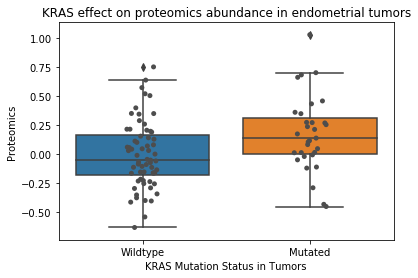

In [62]:
# Step 5 - Create boxplt to compare wildtype and mutated effect on omics data
en_cis_boxplot = sns.boxplot(data = data_for_comparison['data'], x = data_for_comparison['x'],
                          y =data_for_comparison['y'], order = ["Wildtype","Mutated"])  
en_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance in endometrial tumors")
en_cis_boxplot = sns.stripplot(data= data_for_comparison['data'], x = data_for_comparison['x'],
                            y = data_for_comparison['y'],jitter = True, color = ".3", order = ["Wildtype","Mutated"])
en_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

In [19]:
mutation_type_comparison = get_missence_truncation_comparison(en_object, omics, gene)
mutation_type_comparison

Doing t-test comparison



UnboundLocalError: local variable 'only_trunc' referenced before assignment

# Repeat with the Colon dataset

Go through the same process, this time using the Colon dataset. We will only print five genes from the frequently mutated data frame for simplicity.

In [12]:
colon_object = cptac.Colon()
desired_cutoff = .1

colon_freq_mut = al.get_frequently_mutated(colon_object, cutoff=desired_cutoff)
print('\n\nNumber of Frequently Mutated Genes:', len(colon_freq_mut), '\n', colon_freq_mut.head())

matting dataframes...data.....ata....

Number of Frequently Mutated Genes: 612 
      Gene  Unique_Samples_Mut  Missence_Mut  Truncation_Mut
0  ABCA13            0.195876      0.164948        0.103093
1   ABCA2            0.175258      0.164948        0.030928
2   ABCA4            0.144330      0.082474        0.061856
3   ABCB4            0.134021      0.061856        0.072165
4   ABCB6            0.103093      0.061856        0.041237


In [51]:
gene = 'KRAS'

co_omics = colon_object.get_proteomics()
#co_omics = colon_object.get_transcriptomics()
#co_omics = colon_object.get_phosphoproteomics()
#co_omics = colon_object.get_acetylproteomics()

In [52]:
co_data_for_comparison = format_cis_comparison_data(colon_object, co_omics, gene)


Doing t-test comparison

        Comparison   P_Value
0  KRAS_proteomics  0.039128


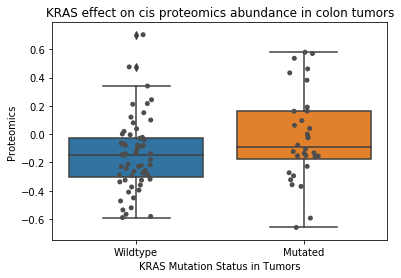

In [53]:
cis_boxplot = sns.boxplot(data = co_data_for_comparison['data'], x = co_data_for_comparison['x'],
                          y = co_data_for_comparison['y'], order = ["Wildtype","Mutated"])  
cis_boxplot.set_title(gene + " effect on cis " + omics.name + " abundance in colon tumors")
cis_boxplot = sns.stripplot(data = co_data_for_comparison['data'], x = co_data_for_comparison['x'],
                            y = co_data_for_comparison['y'], jitter = True, color = ".3", 
                            order = ["Wildtype","Mutated"])
cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

# Repeat with the Ovarian dataset


In [2]:
ovarian_object = cptac.Ovarian()
desired_cutoff = .1

ovarian_freq_mut = al.get_frequently_mutated(ovarian_object, cutoff=desired_cutoff)

In [3]:
gene = 'KRAS'

ov_omics = ovarian_object.get_proteomics()
#ov_omics = ovarian_object.get_transcriptomics()
#ov_omics = ovarian_object.get_phosphoproteomics()
#ov_omics = ovarian_object.get_acetylproteomics()
ovarian_freq_mut

,Gene,Unique_Samples_Mut,Missence_Mut,Truncation_Mut
0,BIRC6,0.120482,0.108434,0.024096
1,FSIP2,0.108434,0.096386,0.024096
2,MT-CO1,0.120482,0.120482,0.000000
3,MT-CO3,0.120482,0.108434,0.012048
4,MT-ND5,0.108434,0.084337,0.024096
5,MUC12,0.144578,0.144578,0.012048
6,MUC16,0.144578,0.144578,0.012048
7,MUC17,0.144578,0.144578,0.000000
8,MUC4,0.325301,0.313253,0.012048
9,MUC5B,0.108434,0.108434,0.000000


In [55]:
ov_data_for_comparison = format_cis_comparison_data(ovarian_object, ov_omics, gene)

exeption with columns. check omics data


In [56]:
# Step 5 - Visualize comparison
ov_cis_boxplot = sns.boxplot(data = ov_data_for_comparison['data'], x = ov_data_for_comparison['x'],
                          y = ov_data_for_comparison['y'], order = ["Wildtype","Mutated"])  
ov_cis_boxplot.set_title(gene + " effect on " + omics.name + " abundance")
ov_cis_boxplot = sns.stripplot(
    data = ov_data_for_comparison['data'], x = ov_data_for_comparison['x'],y = ov_data_for_comparison['y'], 
    jitter = True, color = ".3", order = ["Wildtype","Mutated"])
ov_cis_boxplot.set(xlabel = gene + " Mutation Status in Tumors", ylabel = "Proteomics")
plt.show()

TypeError: 'NoneType' object is not subscriptable